In [40]:
import os
import numpy as np
import tensorflow as tf 
from tensorflow import keras 
from keras import layers, models
from keras.models import Model
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split



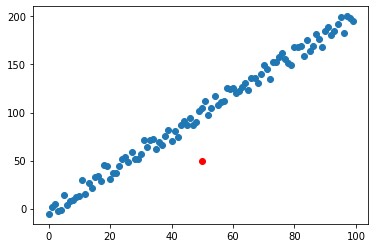

In [41]:
import random

x = []
y = []
for i in range(100):
    x.append(i)
    y.append(i+random.uniform(i-10, i+10))

plt.scatter(x, y)
plt.scatter([50], [50], color='red')
plt.show()

n_att = 1

x = np.asarray(x)
y = np.asarray(y)

    

In [42]:
# # DATA PREPROCESSING
# # load data
# DATA_PATH = 'c:/Users/johns/Desktop/propublica/csv/compas-scores-two-years.csv'
# data = pd.read_csv(DATA_PATH)

# # isolate decile score for truth labels
# truth_labels = data[['decile_score']]

# # drop unwanted dataframes (like redudant ones such as dates)
# data = data[['sex', 'age_cat', 'race', 'juv_fel_count',
#               'juv_misd_count', 'juv_other_count', 'priors_count',
#               'days_b_screening_arrest', 'c_days_from_compas',
#               'c_charge_degree', 'is_recid', 'r_charge_degree', 'r_days_from_arrest']]

# # 1-hot encode categorical data like race, sex etc
# # list object type columns
# cols = []
# for i in range(len(data.columns)):
#     col = data.iloc[:, i]
#     if col.dtype == 'object':
#         cols.append(col.name)

# # replace categorical columns with 1 hot encoding columns for each option
# one_hot_data = pd.get_dummies(data, columns=cols)

# n_att = len(one_hot_data.columns)

# # convert to numpy arrays
# truth_labels = truth_labels.to_numpy()
# one_hot_data = one_hot_data.to_numpy()

# # shuffle and split data into training/validation sets 80:20 ratio *before normalization*
# x_train, x_val, y_train, y_val = train_test_split(one_hot_data, truth_labels, train_size=0.80)

# # scale data
# y_train=np.reshape(y_train, (-1,1))
# y_val=np.reshape(y_val, (-1,1))
# scaler_x = preprocessing.MinMaxScaler()
# scaler_y = preprocessing.MinMaxScaler()
# scaler_x.fit(x_train)
# xtrain_scale=scaler_x.transform(x_train)
# scaler_x.fit(x_val)
# xval_scale=scaler_x.transform(x_val)
# scaler_y.fit(y_train)
# ytrain_scale=scaler_y.transform(y_train)
# scaler_y.fit(y_val)
# yval_scale=scaler_y.transform(y_val)



In [43]:
# MODEL IMPLEMENTATION

# DNN generally only have a single hidden layer, as far as n_nuerons usually you want some
# number between the input and output sizes, one rule of thumb is n_samples / (a *(n_in + n_out))
# where 2 <= a <= 10, gunna use that and play with it as needed, 16's (for n_in=32, n_out=1) a good 
# starting point. Also think treating this as a regression problem makes sense since the decile 
# scores are not categorical and are very much a scale. (originally were thinking softmax so output
# activation is now linear)
n_batch = 20 #32
n_epochs = 5 #int(len(x_train) / n_batch)

# define model 
model = models.Sequential()
model.add(layers.Dense(n_att, input_dim=n_att, kernel_initializer='normal', activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
#model.add(layers.Dense(1, kernel_initializer='normal'))

model.summary()

model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                32        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [44]:
# MODEL TRAINING 1

# train model
# starting with e50 b32 as a jumping off point
history = model.fit(x, y, epochs=50, batch_size=2, verbose=1, validation_split=0.2)

Epoch 1/50
40/40 [==============================] - 0s 4ms/step - loss: 8464.1982 - mse: 8464.1982 - mae: 78.6568 - val_loss: 32644.8086 - val_mse: 32644.8086 - val_mae: 180.2598
Epoch 2/50
40/40 [==============================] - 0s 1ms/step - loss: 8458.3154 - mse: 8458.3154 - mae: 78.6231 - val_loss: 32631.9746 - val_mse: 32631.9746 - val_mae: 180.2242
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 8452.6621 - mse: 8452.6621 - mae: 78.5889 - val_loss: 32618.4062 - val_mse: 32618.4062 - val_mae: 180.1865
Epoch 4/50
40/40 [==============================] - 0s 1ms/step - loss: 8446.8555 - mse: 8446.8555 - mae: 78.5551 - val_loss: 32605.2930 - val_mse: 32605.2930 - val_mae: 180.1501
Epoch 5/50
40/40 [==============================] - 

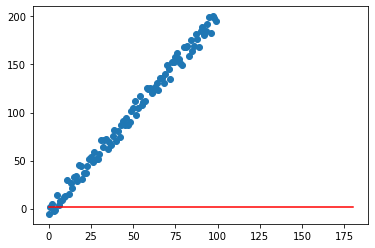

In [45]:
reg_x = []
reg_y = []
for i in range(10):
    n = i * 20
    reg_x.append(model.predict(np.asarray([n]))[0][0])
    reg_y.append(n)


plt.scatter(x, y)
plt.plot(reg_y, reg_x, color='red')
plt.show()


In [46]:
# MODEL TRAINING 2

# havent used keras regressor before but having some kind of trouble with it

# evaluate model
# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold

# estimator = KerasRegressor(build_fn=model, epochs=n_epochs, batch_size=n_batch, verbose=0)
# kfold = KFold(n_splits=10)
# results = cross_val_score(estimator, x_train, y_train, cv=kfold)
# print("model mean and std_dev: %.2f (%.2f) MSE" % (results.mean(), results.std()))